More accurate LDA using Gensim-Mallet, first section is replicating the same gensim LDAModel as previous notebook, second section is the mallet implmentation.

# SECTION 1: Gensim

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint as pp

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy for lemmatization
import spacy

# Plotting
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Prepare nltk stop words and import newgroups.json dataset

In [2]:
# Stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Data
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
# Check DL
print(df.target_names.unique())
print('')
print(df.iat[0,0])
df.head()


['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky 

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


The data we want to analyse is the content, it consists of emails sent to specific target email addresses/groups (of which there are 20)

Therefore, we need to pre-process the emails by removing unnecessary information and characters (email addresses, new line characters, single quotes)

Then use gensims simple_preprocess() to yield tokenised (no punctuation) lists for each document (email)

In [3]:
# Conv to list
data = df.content.values.tolist()

# Strip emails
data = [re.sub('\S*@\S*\s?', '', mail) for mail in data]
# Regex:
# \S* == 'Not a whitespace' '0 or more of the preceeding token'
# \s == 'a whitespace'
# ? == 'match 0 or one of preceeding token'

# Remove new lines and reduce all whitespace to 1
data = [re.sub('\s+', ' ', mail) for mail in data]
# Regex
# + == 'match 1 or more of preceeding token'

# Remove single quotes
data = [re.sub("\'", "", mail) for mail in data]

# Gensim pre-process and tokenisation

def data_to_words(data):
    for line in data:
        # deaccent set to True
        yield(simple_preprocess(str(line), deacc=True))

data_words = list(data_to_words(data))

genrate bi/trigram models 

In [4]:
%%time
# Build the bigram and trigram models
thresh = 100
m_count = 5
bigram = gensim.models.Phrases(data_words, min_count=m_count, threshold=thresh)
trigram = gensim.models.Phrases(bigram[data_words], threshold=thresh)

Wall time: 31.1 s


In [5]:
%%time
# this is meant to be faster but what is the point if you have to run the model first anyway?
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Wall time: 28.7 s


Helper functions for stopwords, bi/trigrams and lemmatisation. Call in order, including trigrams this time

In [6]:
%%time
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words_fin = remove_stopwords(data_words)

data_words_fin = make_bigrams(data_words_fin)

data_words_fin = make_trigrams(data_words_fin)

nlp = spacy.load('en', disable=['parser', 'ner'])
data_words_fin = lemmatization(data_words_fin)

print(data_words_fin[:1])

[['where', 'thing', 'car', 'nntp_posting_host', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]
Wall time: 2min 52s


Create dictionary and corpus (bow per email)

In [7]:
# Dictionary
id2word = corpora.Dictionary(data_words_fin)

# Corpus
corpus = [id2word.doc2bow(mail) for mail in data_words_fin]

# Human readable corpus
hrc = [[(id2word[id], freq) for id, freq in cp] for cp in corpus]
print(hrc[:1])

[[('addition', 1), ('body', 1), ('bricklin', 1), ('bring', 1), ('call', 1), ('car', 5), ('could', 1), ('day', 1), ('door', 2), ('early', 1), ('engine', 1), ('enlighten', 1), ('funky', 1), ('history', 1), ('info', 1), ('know', 1), ('late', 1), ('lerxst', 1), ('line', 1), ('look', 2), ('mail', 1), ('make', 1), ('model', 1), ('name', 1), ('neighborhood', 1), ('nntp_posting_host', 1), ('production', 1), ('really', 1), ('rest', 1), ('see', 1), ('separate', 1), ('small', 1), ('sport', 1), ('tellme', 1), ('thank', 1), ('thing', 1), ('where', 1), ('wonder', 1), ('year', 1)]]


Build model, view topics, generate coherence

In [8]:
%%time
# Build LDA model
k = 20
alpha='auto'
eta=None

def LdaModel(corpus, id2word, k, alpha, eta):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=k, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha=alpha,
                                            eta=eta,
                                            per_word_topics=True)
    return model

lda_model = LdaModel(corpus, id2word, k, alpha, eta)
doc_lda = lda_model[corpus]

pp(lda_model.print_topics())

perplexity = lda_model.log_perplexity(corpus)
coherence_model = CoherenceModel(model=lda_model, texts=data_words_fin, dictionary=id2word, coherence='c_v')
coherence = coherence_model.get_coherence()

print('\nPerplexity: ', perplexity)
print('\nCoherence: ', coherence)

[(0,
  '0.046*"state" + 0.040*"government" + 0.034*"law" + 0.034*"right" + '
  '0.032*"people" + 0.022*"issue" + 0.020*"public" + 0.019*"accept" + '
  '0.016*"country" + 0.015*"member"'),
 (1,
  '0.036*"would" + 0.033*"line" + 0.030*"write" + 0.019*"article" + '
  '0.018*"know" + 0.016*"go" + 0.016*"be" + 0.015*"get" + 0.014*"make" + '
  '0.014*"think"'),
 (2,
  '0.046*"player" + 0.042*"home" + 0.028*"fire" + 0.028*"fan" + 0.027*"goal" + '
  '0.025*"watch" + 0.023*"family" + 0.022*"ground" + 0.021*"minute" + '
  '0.016*"cd"'),
 (3,
  '0.077*"logic" + 0.063*"page" + 0.041*"homosexual" + 0.039*"table" + '
  '0.035*"draft" + 0.029*"aware" + 0.029*"cable" + 0.026*"connector" + '
  '0.023*"conference" + 0.021*"tree"'),
 (4,
  '0.160*"space" + 0.084*"display" + 0.053*"launch" + 0.048*"motif" + '
  '0.043*"mission" + 0.042*"orbit" + 0.038*"satellite" + 0.034*"flight" + '
  '0.024*"moon" + 0.022*"shuttle"'),
 (5,
  '0.097*"box" + 0.066*"should" + 0.047*"ticket" + 0.043*"cap" + '
  '0.034*"stre

In [ ]:
%%time
# Visualise
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

# SECTION 2: Mallet

Mallet's algorithm is supposedly faster and more accurate than the gensim ldamulticore. It is not a gensim function, but gensim does have a wrapper to use it via.

In [24]:
%%time
def LdaMallet(corpus, topics, id2word):
    # Ensure mallet env is set correctly and the path is correctly escaped
    import os
    os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})
    mallet_path = 'C:\\mallet-2.0.8\\bin\\mallet' # update this path
    return gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topics, id2word=id2word)

k = 20
lda_mallet = LdaMallet(corpus, k, id2word)

pp(lda_mallet.show_topics(formatted=True))

coherence_model_mallet = CoherenceModel(model=lda_mallet, texts=data_words_fin, dictionary=id2word, coherence='c_v')
coherence_mallet = coherence_model_mallet.get_coherence()

print('\nCoherence: ', coherence_mallet)

[(1,
  '0.011*"drug" + 0.010*"study" + 0.008*"food" + 0.008*"doctor" + '
  '0.008*"effect" + 0.007*"problem" + 0.007*"patient" + 0.007*"eat" + '
  '0.007*"report" + 0.006*"disease"'),
 (5,
  '0.017*"people" + 0.010*"war" + 0.009*"attack" + 0.009*"israeli" + '
  '0.009*"land" + 0.009*"kill" + 0.009*"government" + 0.008*"turkish" + '
  '0.007*"world" + 0.007*"give"'),
 (14,
  '0.016*"exist" + 0.016*"question" + 0.015*"claim" + 0.014*"argument" + '
  '0.014*"reason" + 0.011*"evidence" + 0.011*"true" + 0.011*"point" + '
  '0.009*"human" + 0.009*"atheist"'),
 (8,
  '0.020*"space" + 0.011*"system" + 0.009*"launch" + 0.008*"project" + '
  '0.008*"year" + 0.008*"technology" + 0.007*"design" + 0.007*"material" + '
  '0.006*"satellite" + 0.006*"time"'),
 (17,
  '0.041*"file" + 0.019*"program" + 0.015*"image" + 0.014*"include" + '
  '0.014*"version" + 0.011*"software" + 0.009*"source" + 0.009*"information" + '
  '0.008*"format" + 0.008*"entry"'),
 (0,
  '0.031*"system" + 0.030*"drive" + 0.029*"ca

Using Mallet has increased the coherence. Now we should identify the optimal k value.

In [26]:
%%time

def calculate_cv(corpus, id2word, texts, k_max, k_min=2, step=2):
    results = []
    for value in range(k_min, k_max, step):
        print(value, " - Started")
        model = LdaMallet(corpus, value, id2word)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence = coherence_model.get_coherence()
        results.append([value, coherence, model])
        print(value, " - Done \n")
        
    return results

res = calculate_cv(corpus, id2word, data_words_fin, k_max=30, k_min=2)

2  - Started
2  - Done 

4  - Started
4  - Done 

6  - Started
6  - Done 

8  - Started
8  - Done 

10  - Started
10  - Done 

12  - Started
12  - Done 

14  - Started
14  - Done 

16  - Started
16  - Done 

18  - Started
18  - Done 

20  - Started
20  - Done 

22  - Started
22  - Done 

24  - Started
24  - Done 

26  - Started
26  - Done 

28  - Started
28  - Done 

Wall time: 27min 44s


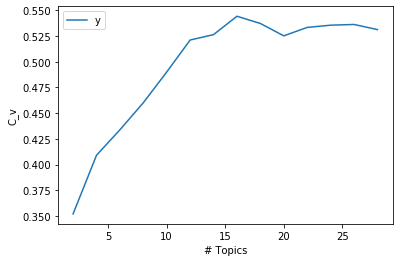

In [28]:
# Plot Graph
x = [x[0] for x in res]
y = [y[1] for y in res]

plt.plot(x,y)
plt.xlabel("# Topics")
plt.ylabel("C_v")
plt.legend(("y"), loc='best')
plt.show()

In [42]:
for x in res:
    print('Topics: ', x[0], 'Has C_v: ', x[1])

cv = [x[1] for x in res]
cv_mi = cv.index(max(cv))

res_m = res[cv_mi]

print("\nThe optimal topic no is:", res_m[0], "with a C_v of:", res_m[1])

Topics:  2 Has C_v:  0.35191070708456007
Topics:  4 Has C_v:  0.40898497788898835
Topics:  6 Has C_v:  0.43376583495743776
Topics:  8 Has C_v:  0.46012021336612197
Topics:  10 Has C_v:  0.49003496604078495
Topics:  12 Has C_v:  0.521156452109142
Topics:  14 Has C_v:  0.5264294090814465
Topics:  16 Has C_v:  0.5443027345659504
Topics:  18 Has C_v:  0.5372535633463703
Topics:  20 Has C_v:  0.5252236997647125
Topics:  22 Has C_v:  0.5334393809523557
Topics:  24 Has C_v:  0.5355914104974882
Topics:  26 Has C_v:  0.5362923511654506
Topics:  28 Has C_v:  0.5313223351067804

The optimal topic no is: 16 with a C_v of: 0.5443027345659504


However, we know that there are 20 different topics that we want to extract. A way forward would be to look to optimise the hyperparameters to get the best c_v for k = 20.

Lets look at what the k=20 model yields.

In [45]:
model_o = res[9][2]
model_topics = model_o.show_topics(formatted=False)
pp(model_o.print_topics(num_words=10))

[(0,
  '0.023*"people" + 0.016*"man" + 0.012*"love" + 0.011*"life" + 0.011*"make" + '
  '0.011*"religion" + 0.010*"christian" + 0.009*"church" + 0.008*"world" + '
  '0.008*"faith"'),
 (1,
  '0.050*"good" + 0.032*"year" + 0.026*"make" + 0.025*"bad" + 0.019*"run" + '
  '0.018*"lot" + 0.016*"thing" + 0.016*"time" + 0.015*"hit" + 0.015*"start"'),
 (2,
  '0.033*"car" + 0.013*"power" + 0.009*"ground" + 0.008*"light" + 0.008*"wire" '
  '+ 0.008*"current" + 0.008*"water" + 0.008*"high" + 0.008*"engine" + '
  '0.006*"low"'),
 (3,
  '0.032*"problem" + 0.026*"system" + 0.026*"card" + 0.025*"bit" + '
  '0.021*"driver" + 0.019*"work" + 0.016*"run" + 0.014*"speed" + '
  '0.014*"machine" + 0.014*"memory"'),
 (4,
  '0.040*"post" + 0.033*"find" + 0.032*"read" + 0.026*"book" + 0.019*"time" + '
  '0.017*"question" + 0.017*"point" + 0.014*"write" + 0.014*"give" + '
  '0.013*"problem"'),
 (5,
  '0.020*"image" + 0.017*"software" + 0.016*"mail" + 0.015*"include" + '
  '0.015*"version" + 0.012*"list" + 0.012*

We now want to identify what each document is about by using the LDA to assign the most probable topic.

In [205]:
def document_topic(ldamodel, corpus, texts):
    # Output is a df
    document_topic_df = pd.DataFrame()
    
    # Get dominant topic for each doc
    for i, row in enumerate(ldamodel[corpus]):
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True) # this sorts by probability value, so the first element has the largest p 
        for j, (topic_num, topic_val) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num) # word/probability bin for given topic
                topic_keywords = ','.join([word for word, val in wp]) # aggregate words into list
                document_topic_df = document_topic_df.append(pd.Series([int(topic_num), round(topic_val,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topic_df.columns=['Topic', 'Probability', 'Keywords']
    
    # Add original text at the end
    contents = pd.Series(texts)
    document_topic_df = pd.concat([document_topic_df, contents], axis=1)
    return document_topic_df

topic_dist = document_topic(model_o, corpus, data)
topic_dist = topic_dist.reset_index()
topic_dist.columns = ['Doc_#', 'Main_Topic', '%_contrib', 'Keywords', 'Text']

topic_dist.head(10)


,Doc #,Main Topic,% contrib,Keywords,Text
0,0,2.0,0.1131,"car,power,ground,light,wire,current,water,high...",From: (wheres my thing) Subject: WHAT car is t...
1,1,3.0,0.1607,"problem,system,card,bit,driver,work,run,speed,...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,3.0,0.1197,"problem,system,card,bit,driver,work,run,speed,...",From: (Thomas E Willis) Subject: PB questions....
3,3,15.0,0.0960,"write,article,line,organization,hear,opinion,n...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,6.0,0.1532,"file,window,program,set,line,application,serve...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,13.0,0.2872,"gun,law,people,state,case,fire,crime,kill,weap...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,10.0,0.0874,"drug,study,problem,food,doctor,effect,patient,...",From: (brian manning delaney) Subject: Brain T...
7,7,3.0,0.4796,"problem,system,card,bit,driver,work,run,speed,...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,6.0,0.1208,"file,window,program,set,line,application,serve...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,3.0,0.1971,"problem,system,card,bit,driver,work,run,speed,...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


A good way to identify the actual semantic meaning of a topic is to find the document that it describes the most and then have a human read that document and classify the topic.

In [206]:
# Fucntion to extract the top document per topic
topics_top = pd.DataFrame()
topics_arranged = topic_dist.groupby('Main_Topic')

for i, grp in topics_arranged:
    topics_top = pd.concat([topics_top, grp.sort_values(['%_contrib'], ascending=[0]).head(1)], axis=0)

topics_top.reset_index(drop=True, inplace=True)

topics_top.head(20)

,Doc_#,Main_Topic,%_contrib,Keywords,Text
0,7751,0.0,0.5788,"people,man,love,life,make,religion,christian,c...",From: (Family Magazine Sysops) Subject: WITNES...
1,7528,1.0,0.5492,"good,year,make,bad,run,lot,thing,time,hit,start",From: Mamatha Devineni Ratnam Subject: Zane!!R...
2,2339,2.0,0.7311,"car,power,ground,light,wire,current,water,high...","From: Subject: Grounding power wiring, was Re:..."
3,10876,3.0,0.6260,"problem,system,card,bit,driver,work,run,speed,...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
4,4816,4.0,0.5262,"post,find,read,book,time,question,point,write,...","From: (Frank DeCenso, Jr.) Subject: BIBLICAL C..."
5,3864,5.0,0.7473,"image,software,mail,include,version,list,file,...",From: (Nick C. Fotis) Subject: (17 Apr 93) Com...
6,1704,6.0,0.9253,"file,window,program,set,line,application,serve...",From: (Landon C. Noll) Subject: Reposting: 10t...
7,491,7.0,0.6684,"question,exist,reason,argument,true,evidence,c...",From: mathew Subject: Alt.Atheism FAQ: Constru...
8,7139,8.0,0.6911,"group,make,question,issue,work,receive,informa...",From: (Clinton/Gore 92) Subject: CLINTON: AM P...
9,6539,9.0,0.6983,"people,kill,attack,war,israeli,turkish,land,go...",From: Center for Policy Research Subject: Fina...


A final analysis would be to determine the topic distribution across the documents to identify the most common dominent topics.

We could also look at identifying this for non dominant (2nd/3rd/4th etc) to see what topics may be linked?

In [207]:
# No of documents for each topic
topic_counts = topic_dist['Main_Topic'].value_counts()

# Overall % of documents per topic
topic_percent = round(topic_counts/topic_counts.sum(), 4)

# topic no + words
topic_keywords = topics_top[['Main_Topic', 'Keywords']]

dominant_topics = pd.concat([topic_keywords,topic_counts, topic_percent], axis=1)
dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Count', 'Percent']
dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Count,Percent
0.0,0.0,"people,man,love,life,make,religion,christian,c...",649,0.0574
1.0,1.0,"good,year,make,bad,run,lot,thing,time,hit,start",448,0.0396
2.0,2.0,"car,power,ground,light,wire,current,water,high...",790,0.0698
3.0,3.0,"problem,system,card,bit,driver,work,run,speed,...",1167,0.1031
4.0,4.0,"post,find,read,book,time,question,point,write,...",366,0.0323
5.0,5.0,"image,software,mail,include,version,list,file,...",668,0.0590
6.0,6.0,"file,window,program,set,line,application,serve...",637,0.0563
7.0,7.0,"question,exist,reason,argument,true,evidence,c...",435,0.0384
8.0,8.0,"group,make,question,issue,work,receive,informa...",224,0.0198
9.0,9.0,"people,kill,attack,war,israeli,turkish,land,go...",492,0.0435


# SECTION 3: Visualisation Methods 

Word count distrubution of documents.

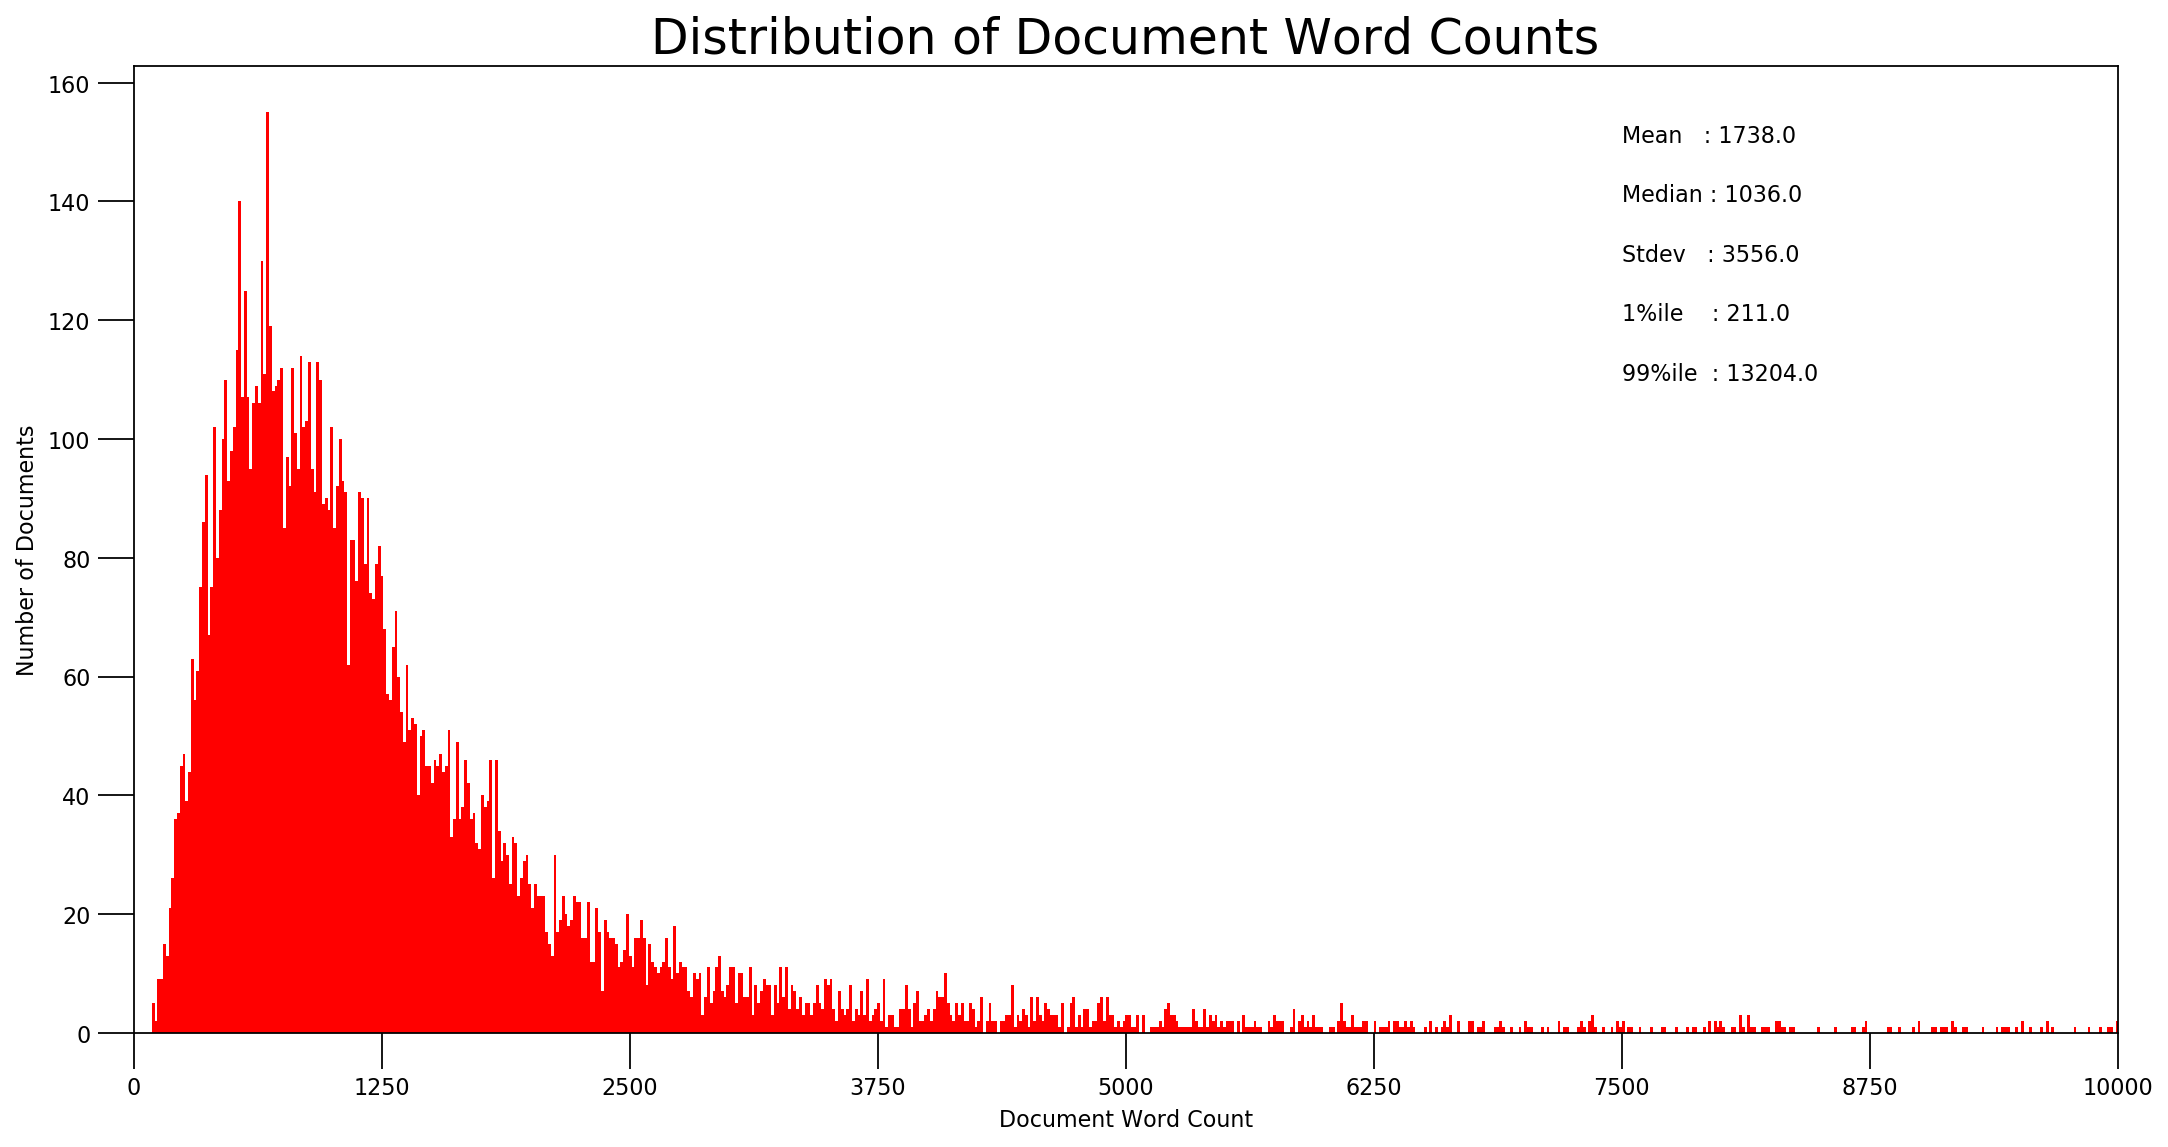

In [216]:
import seaborn as sns

doc_len = [len(d) for d in topic_dist.Text]
doc_len.sort()

plt.figure(figsize=(16,8), dpi=160)
plt.hist(doc_len, bins = 5000, color = 'red')
plt.text(7500, 150, "Mean   : " + str(round(np.mean(doc_len))))
plt.text(7500,  140, "Median : " + str(round(np.median(doc_len))))
plt.text(7500,  130, "Stdev   : " + str(round(np.std(doc_len))))
plt.text(7500,  120, "1%ile    : " + str(round(np.quantile(doc_len, q=0.01))))
plt.text(7500,  110, "99%ile  : " + str(round(np.quantile(doc_len, q=0.99))))

plt.gca().set(xlim=(0, 10000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,10000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

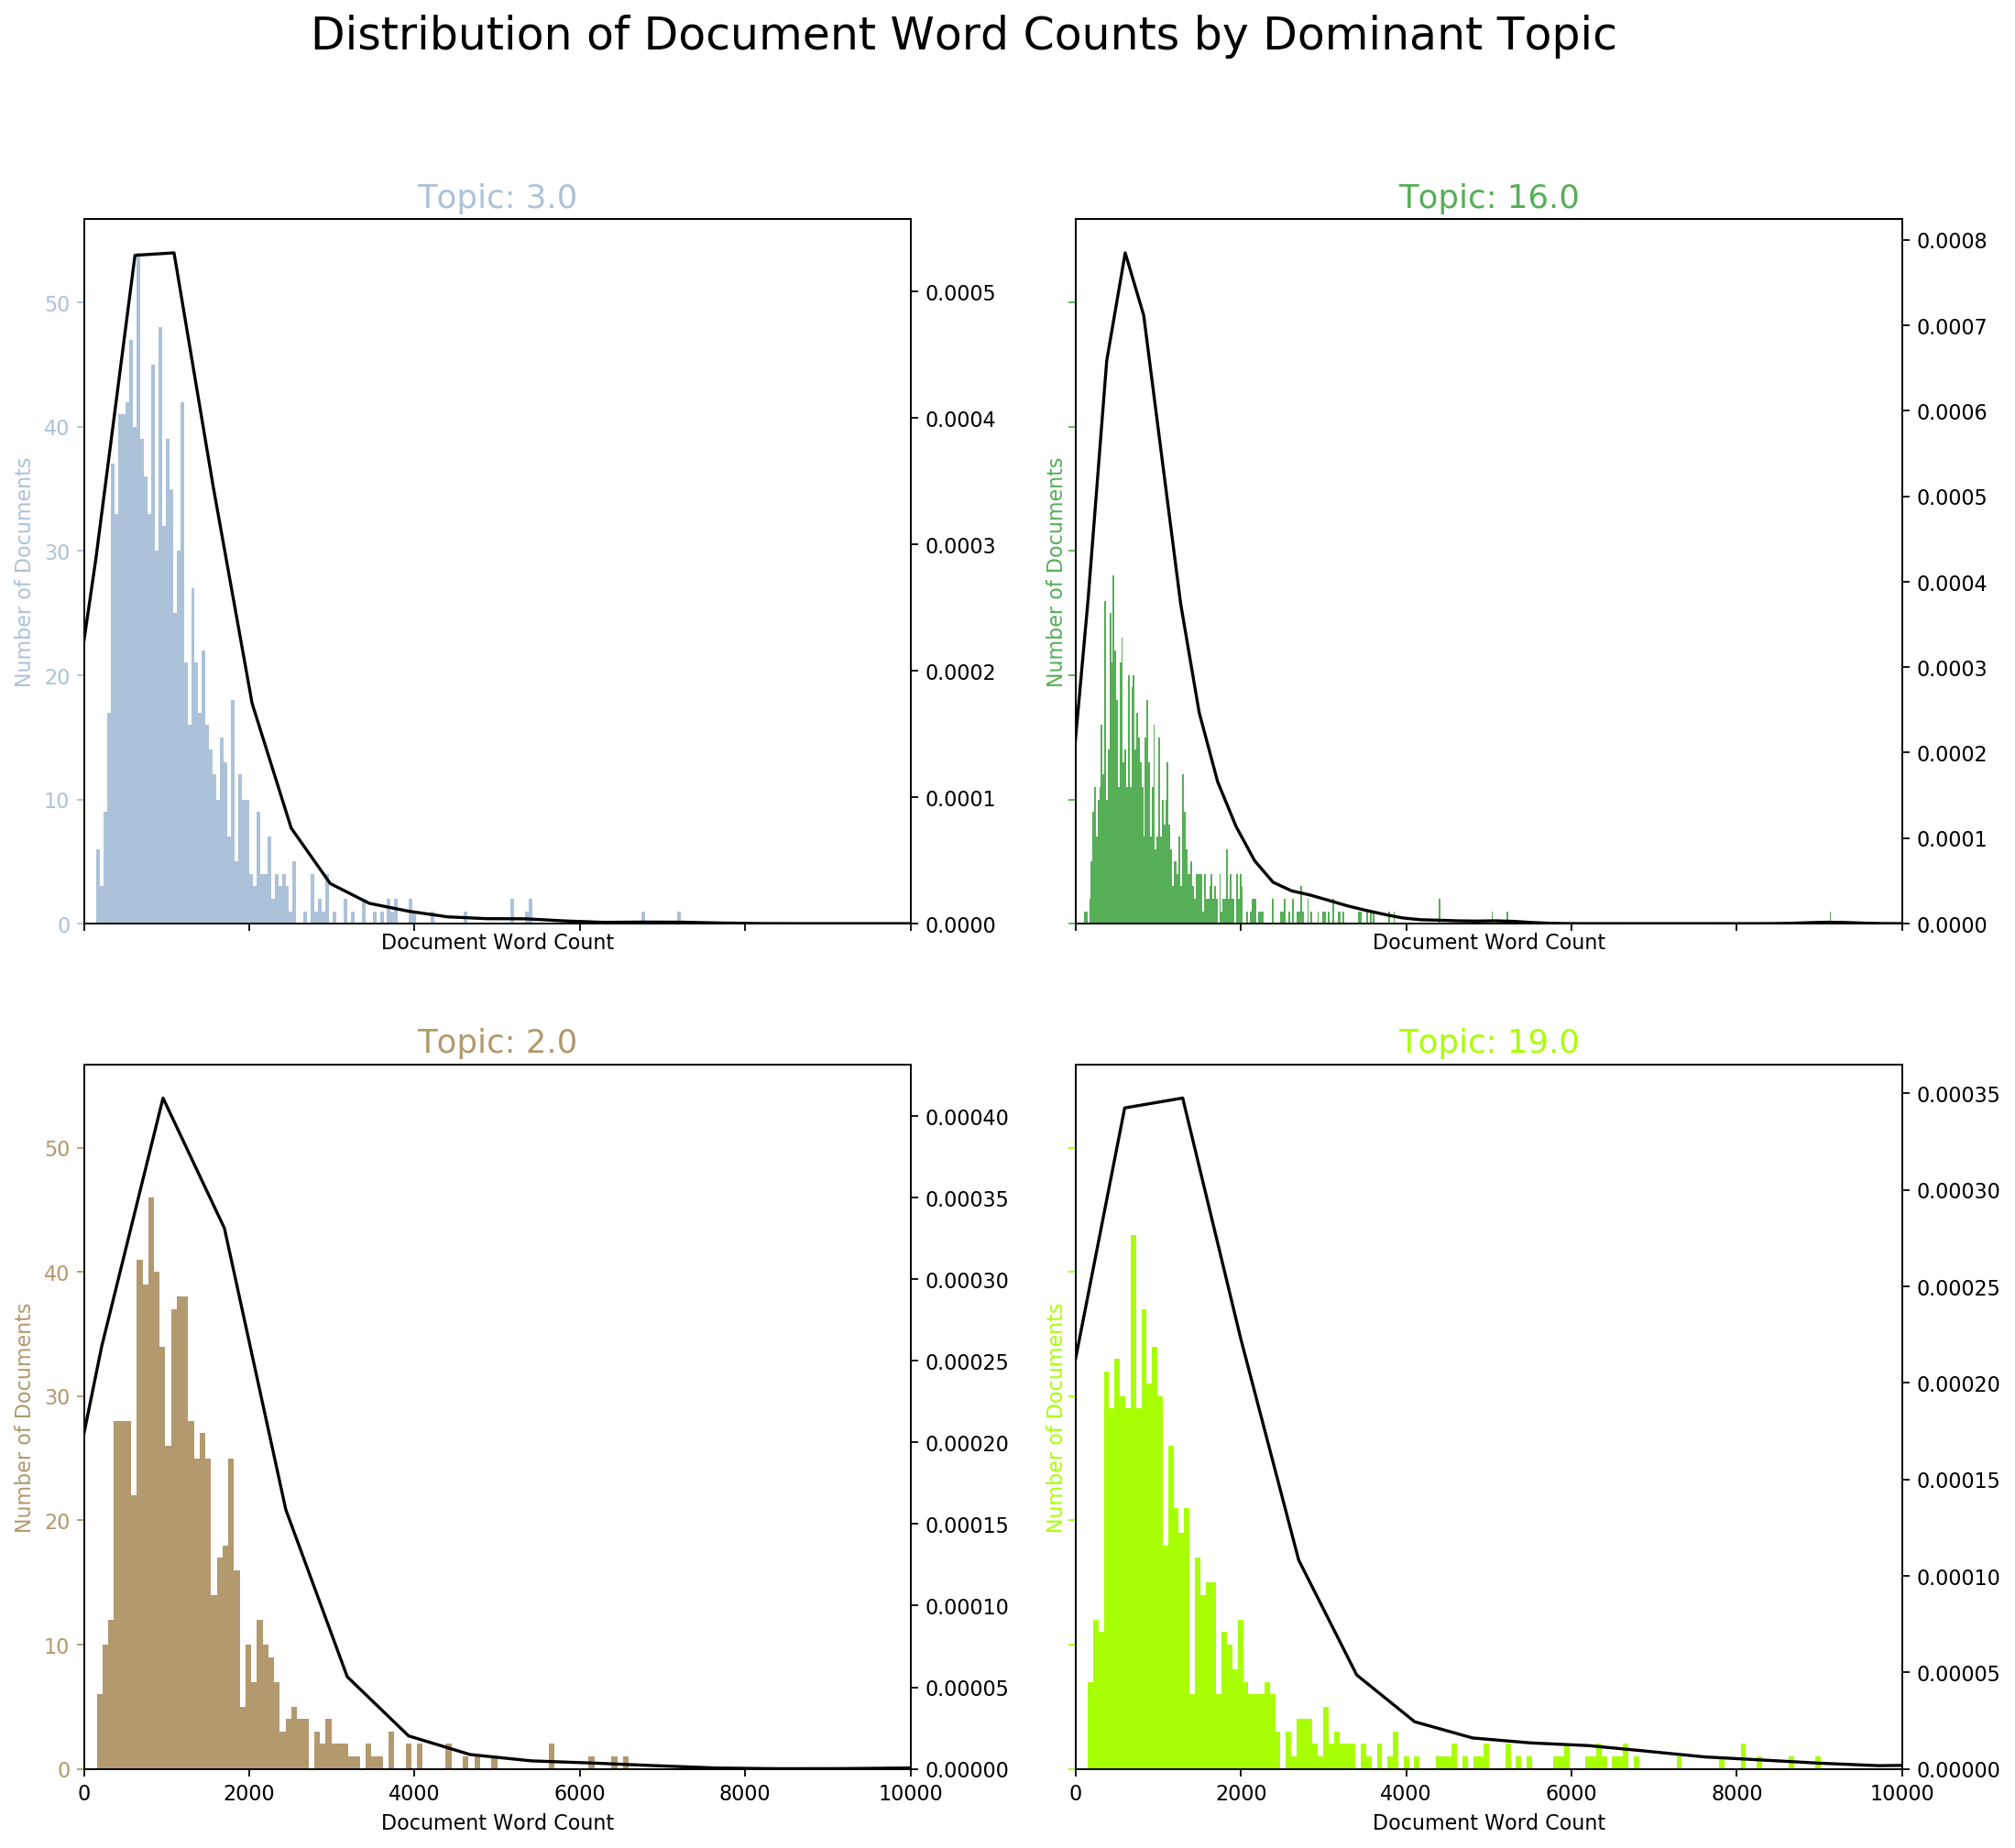

In [212]:
import matplotlib.colors as mcolors

# Set up colours and subplots
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

# Extract top 4 dominant topic values
dt = dominant_topics.sort_values(['Count'], ascending=[0]).head(4)
dt = [x for x in dt['Dominant_Topic'].values]

# loop over the plots and plot the word count distribution filtered per topic, underneath the full dist
for i, ax in enumerate(axes.flatten()):
    t = dt[i]
    topic_dist_filtered = topic_dist.loc[topic_dist.Main_Topic == t, :]
    doc_len_f = [len(d) for d in topic_dist_filtered.Text]
    ax.hist(doc_len_f, bins = 1000, color=cols[i]) # plot histogram for topic
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_len_f, color="black", shade=False, ax=ax.twinx()) # plot kernel density estimate (== posterior probability density estimate of a random set of results?)
    ax.set(xlim=(0, 10000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(t), fontdict=dict(size=16, color=cols[i]))
    
    fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)

We now want to show the word counts of topic keywords vs the probability of the keyword

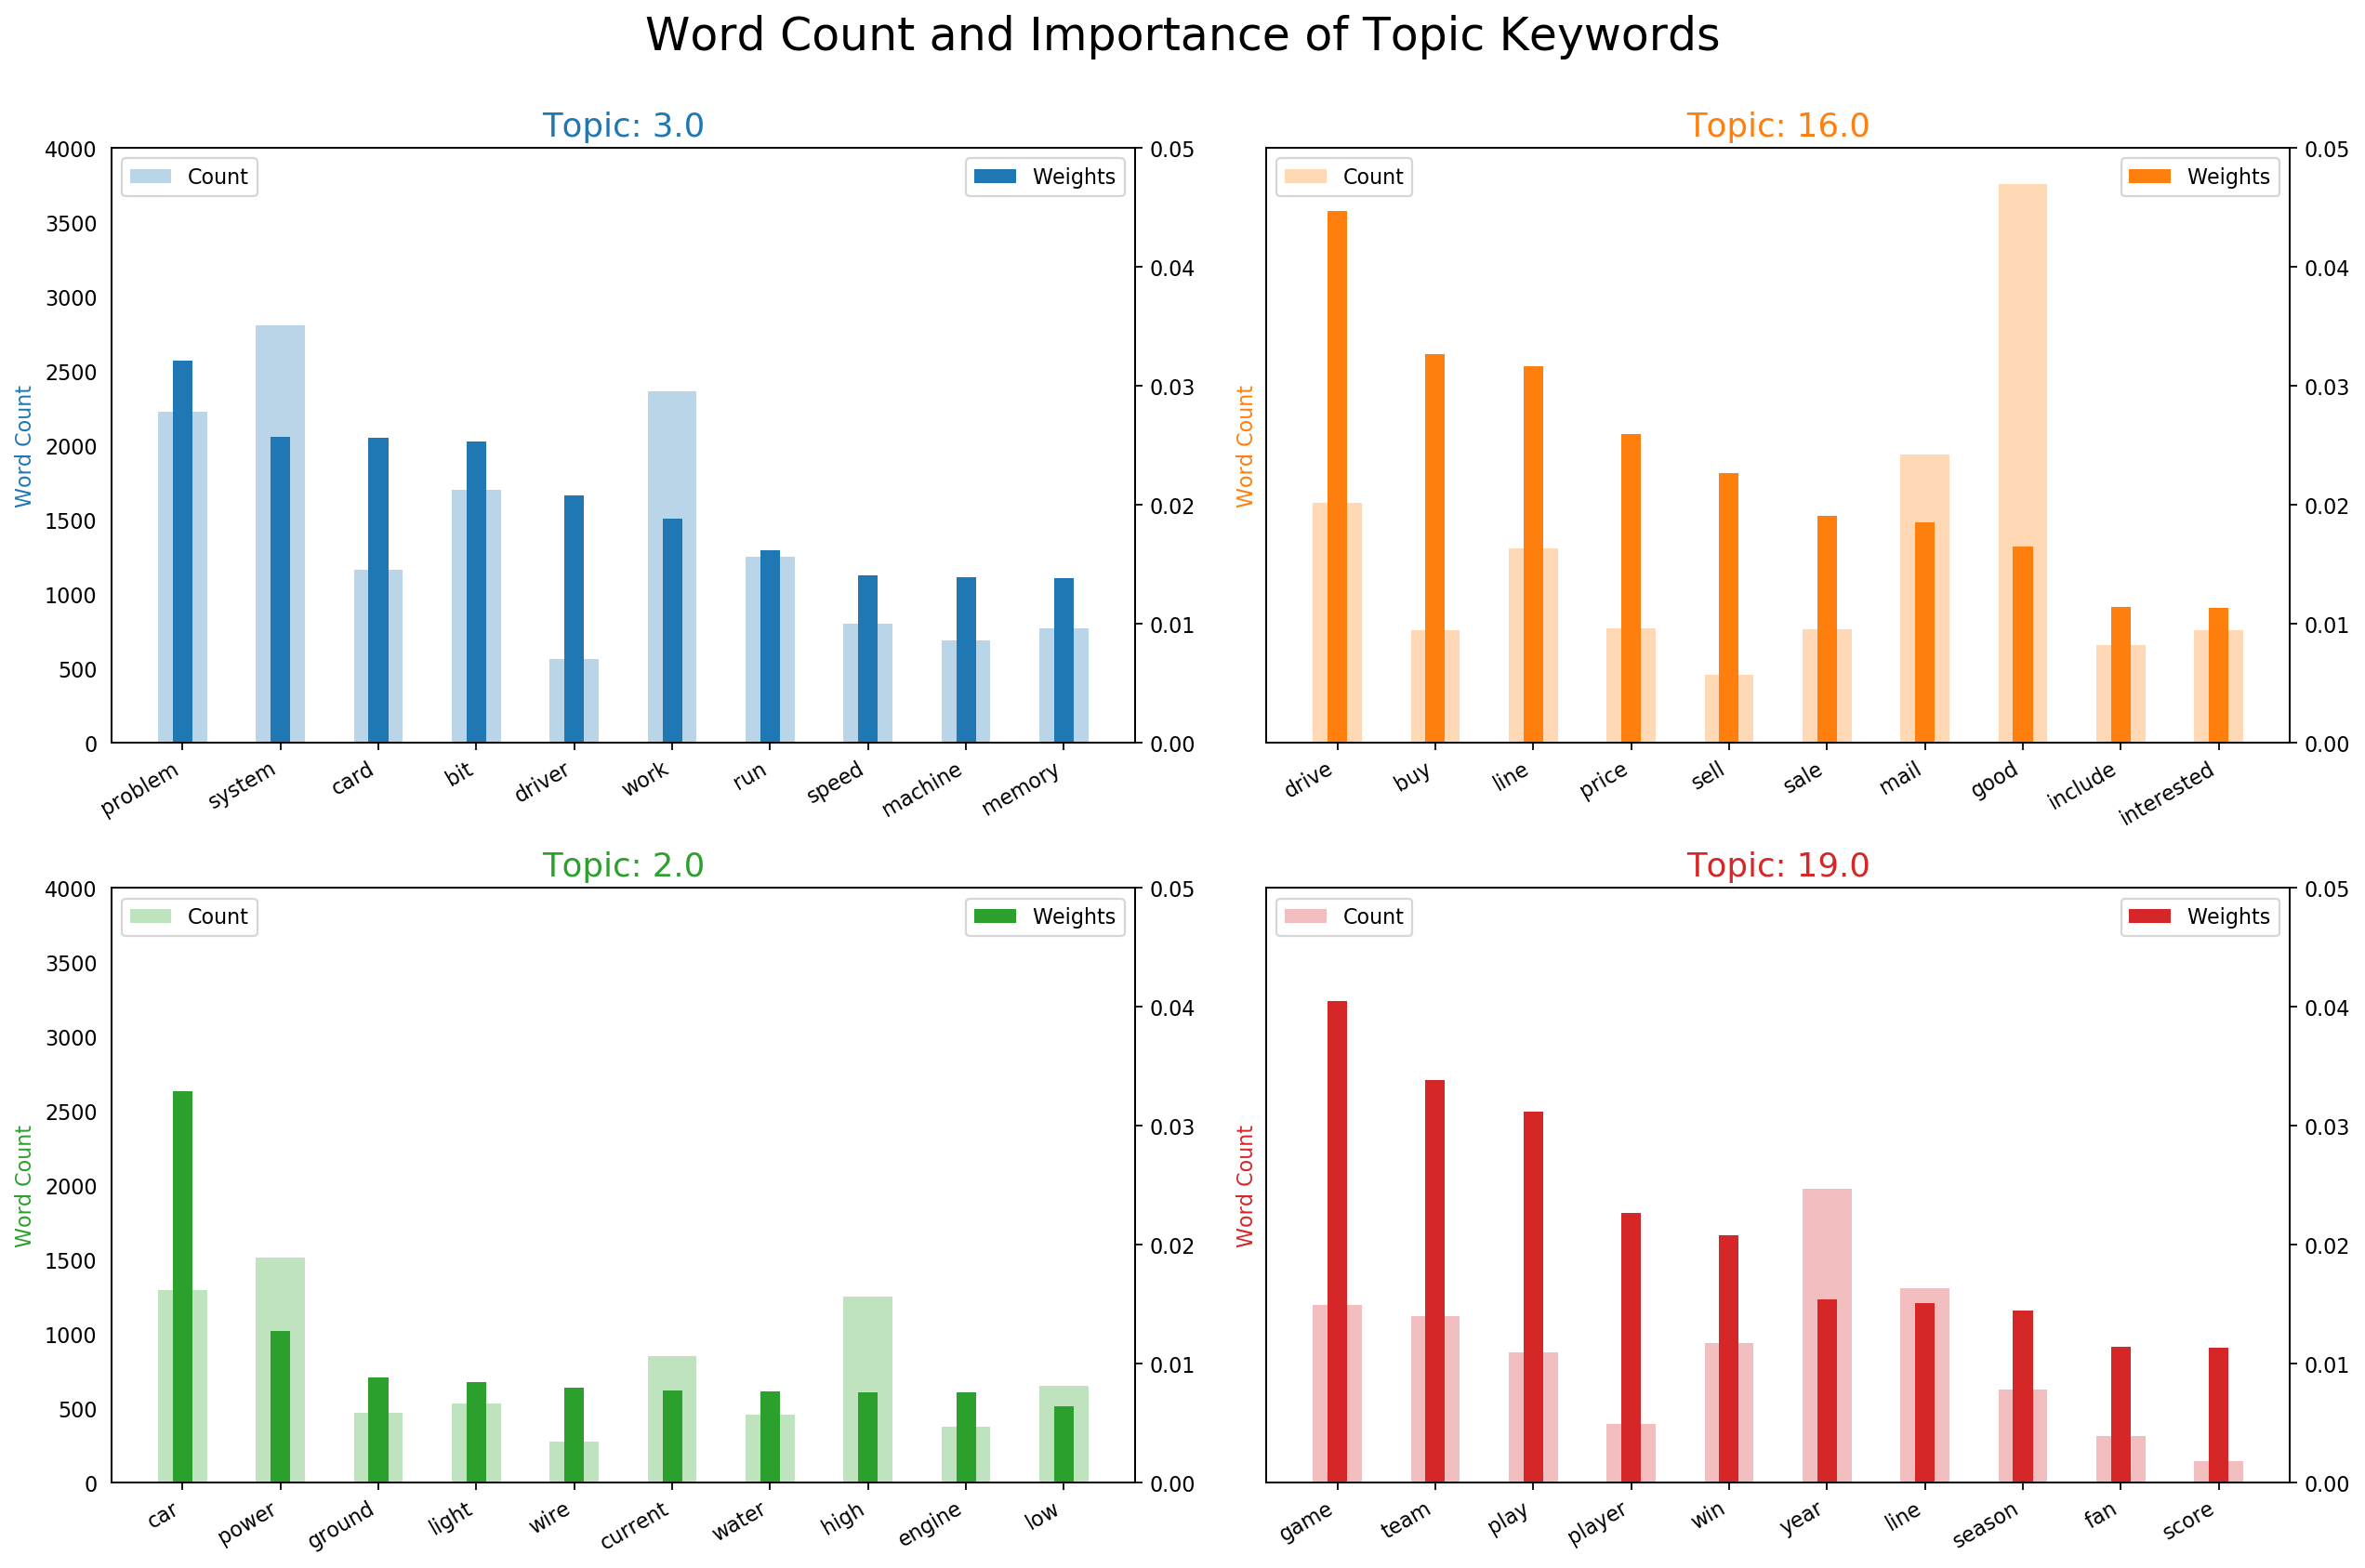

In [252]:
from collections import Counter
topics = model_o.show_topics(20, formatted=False)

data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

# generate data
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic', 'weight', 'count'])

# generate subplots
fig,axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    t = dt[i]
    ax.bar(x='word', height='count', data=df.loc[df.topic==t], color=cols[i], width=0.5, alpha=0.3, label='Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="weight", data=df.loc[df.topic==t, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.050); ax.set_ylim(0, 4000)
    ax.set_title('Topic: ' + str(t), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic==t, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
    fig.tight_layout(w_pad=2) 
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

The above graphs are good for identifying Junk and Insignificant (J/I) topics and words. 

If a word has a relative frequency (count) that is significantly larger than its weight, then it is likely that the word isn't actually relevant to the topic, is contained within multiple topics, and therefor dosen't provide much semantic value

For instance, in topic 16, 'good' hasa count that is over double the weight for the topic. This is likely because good is descriptive and is used in other topics to describe different things, and is not just linked to selling/buying

Next we are going to use t_SNE to show the document relationship in a 2d space for the top 4 topics, this will give us some understanding of how closely these topics are related.

In [255]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [327]:
%%time
weights = []
for i, row in enumerate(model_o[corpus]):
    weights.append([w for i, w in row])

# Put into a df and keep only the well separated points
ar_weights = pd.DataFrame(weights).fillna(0).values
#ar_weightss = ar_weights[np.amax(ar_weights, axis=1) > 0.35] # <-- this massively reduces the set

# extract the top 4 (2,3,16,19)
xt = [2,3,16,19]
ar_weights = ar_weights[:,xt]


# df of dominant topic no for each 
topic_num = np.argmax(ar_weights, axis=1)

#t-SNE model
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(ar_weights)

#plot the dist
output_notebook()
n_topics = 4
mycolours = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolours[topic_num], legend_label=str(topic_num))
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.014s...
[t-SNE] Computed neighbors for 11314 samples in 0.607s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.003956
[t-SNE] KL divergence

Loading BokehJS ...

Wall time: 1min 20s


0 = 2 = blue

1 = 3 = orange

2 = 16 = green

3 = 19 = red